# Lab 8 - Spatially Constrained Clustering
# Partitioning Methods

This notebook continues with methods that impose *hard* spatial constraints in a clustering procedure. We consider two methods that use a partitioning clustering logic: AZP (automatic zoning procedure) and max-p, covered in Chapter 11 of Anselin (2024).

It is part of the Spatial Cluster Analysis course taught at the University of Chicago in the Winter Quarter of 2025.

Prepared by: Luc Anselin (anselin@uchicago.edu) and Pedro Amaral (pedroamaral@uchicago.edu)

## Preliminaries
The empirical illustration is based on the material in Chapter 11 of the Spatial Cluster book.

### Required packages

The conda enviroment used for this exercise was created from a yml file with the same specification as in the previous notebooks:

In addition to the usual `numpy` and `geopandas`, we also import `pygeoda` to carry out the cluster analysis. To make sure the latest version is installed (0.0.8-1), use `pip install -U pygeoda`. We include a check after the import statements.

As before, we import several functions from the `spatial_cluster_course` utility module:

- `cluster_stats`
- `cluster_fit`
- `cluster_center`
- `cluster_map`

In [1]:
import geopandas as gpd
import numpy as np
from spatial_cluster_course import cluster_stats, cluster_fit, cluster_center, cluster_map
import pygeoda
print("Pygeoda version: ", pygeoda.__version__)

Pygeoda version:  0.0.8-1


### Load data

For this exercise, we continue to use the same data set as before on Zika and Microcephaly infections and socio-economic profiles for 2013-2016 in municipalities in the State of Ceará, Brazil. This is also a GeoDa sample data set. Detailed source and information available at https://geodacenter.github.io/data-and-lab/Ceara-Zika/

The following files will be used:
- **ceara.shp,shx,dbf,prj**: shape file (four files) for 184 municipalities

We follow the usual practice of setting a path (if needed), reading the data from the shape file and a quick check of its contents (`head`).

In [2]:
# Setting working folder:
#path = "/your/path/to/data/"
path = ""

# Load the Ceará data:
dfs = gpd.read_file(path+"ceara/ceara.shp")
print(dfs.shape)
dfs.head(3)

(184, 36)


,code7,mun_name,state_init,area_km2,state_code,micro_code,micro_name,inc_mic_4q,inc_zik_3q,inc_zik_2q,...,gdp,pop,gdpcap,popdens,zik_1q,ziq_2q,ziq_3q,zika_d,mic_d,geometry
0,2300101.0,Abaiara,CE,180.833,23,23019,19Âª RegiÃ£o Brejo Santo,0.000000,0.0,0.00,...,35974.0,10496.0,3.427,58.043,0.0,0.0,0.0,0.0,0.0,"POLYGON ((5433729.65 9186242.97, 5433688.546 9..."
1,2300150.0,Acarape,CE,130.002,23,23003,3Âª RegiÃ£o MaracanaÃº,6.380399,0.0,0.00,...,68314.0,15338.0,4.454,117.983,0.0,0.0,0.0,0.0,1.0,"POLYGON ((5476916.288 9533405.667, 5476798.561..."
2,2300200.0,AcaraÃº,CE,842.471,23,23012,12Âª RegiÃ£o AcaraÃº,0.000000,0.0,1.63,...,309490.0,57551.0,5.378,68.312,0.0,1.0,0.0,1.0,0.0,"POLYGON ((5294389.783 9689469.144, 5294494.499..."


In [3]:
# the full set of variables
print(list(dfs.columns))

['code7', 'mun_name', 'state_init', 'area_km2', 'state_code', 'micro_code', 'micro_name', 'inc_mic_4q', 'inc_zik_3q', 'inc_zik_2q', 'inc_zik_1q', 'prim_care', 'ln_gdp', 'ln_pop', 'mobility', 'environ', 'housing', 'sanitation', 'infra', 'acu_zik_1q', 'acu_zik_2q', 'acu_zik_3q', 'pop_zikv', 'acu_mic_4q', 'pop_micro', 'lngdpcap', 'gdp', 'pop', 'gdpcap', 'popdens', 'zik_1q', 'ziq_2q', 'ziq_3q', 'zika_d', 'mic_d', 'geometry']


#### Selecting variables and checking their correlation

Following Chapter 11 of Anselin (2024) (https://lanselin.github.io/introbook_vol2/CHspatialpartition.html), we select the following variables from the Ceará sample data set.

List of variables:
| Column Name | Description                                      |
|-------------|--------------------------------------------------|
| mobility    | Mobility index                                  |
| environ     | Environment index                               |
| housing     | Housing index                                  |
| sanitation  | Sanitation index                               |
| infra       | Infrastructure index                           |
| gdpcap      | GDP per capita                                  | 



We specify the variables in a list for later use.

In [5]:
varlist = ['mobility', 'environ', 'housing', 'sanitation', 'infra', 'gdpcap']

As in the previous notebook, we also use the geo data frame to create a data object that is compatible with `pygeoda` using its `open` command. In addition, we create queen contiguity weights using `queen_weights` and briefly check their characteristics.

In [6]:
ceara_g = pygeoda.open(dfs)
queen_w = pygeoda.queen_weights(ceara_g)
queen_w

Weights Meta-data:
 number of observations:                  184
           is symmetric:                 True
               sparsity:  0.02953686200378072
        # min neighbors:                    1
        # max neighbors:                   13
       # mean neighbors:    5.434782608695652
     # median neighbors:                  5.0
           has isolates:                False

Because we will be using `pygeoda` for the clustering algorithms, we need the relevant variables in a pygeoda data format. However, because we will also use the various helper functions from the `pysal_cluster_course` module, we will need a geo data frame subset as well. We extract the variables respectively as `data` (geo data frame) and `data_g` (for pygeoda) for future use.

In [7]:
data = dfs[varlist]
data_g = ceara_g[varlist]

## AZP

The first spatially constrained partitioning method we consider is AZP. It is contained in `pygeoda`, which uses the same underlying code as `GeoDa` except for some technical implementations related to memory management. Even though these differences are very low-level, they can influence the way the heuristic proceeds, since it moves sequentially through alternative configurations. The order in which these sequences are considers matters, and slight differences in the memory allocation can produce different results.

As a consequence, it is not possible to completely replicate the results from Chapter 11, given the differences between the low-level implementations in C++ and in Python. This is a general feature of any heuristic, where not only the algorithms matter, but also seemingly unrelated issues such as starting points, random numbers and the particular ordering of moves.

AZP is implemented as three different functions, corresponding to the *greedy*, *tabu* and *simulated annealing* optimization approaches. The matching functions are `azp_greedy`, `azp_tabu`, and `azp_sa`. Required arguments are the number of clusters, the spatial weights and the pygeoda data object.

In [8]:
n_clusters = 12

### AZP-Greedy

The first example uses greedy search, implemented in `azp_greedy`. We use the same approach as in the previous notebook and employ the helper functions `cluster_stats`, `cluster_fit`, `cluster_center` and `cluster_map` to list the properties of the clusters (see the previous notebook for technical details).

    Labels  Cardinality
0        1           46
1        2           37
2        3           29
3        4           25
4        5           21
5        6            7
6        7            5
7        8            5
8        9            4
9       10            2
10      11            2
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.    124.036 115.162 139.302  71.455 105.922  16.194  16.279  26.967
  53.98    2.921  16.99 ]
Total Within-cluster Sum of Squares (WSS): 689.208
Between-cluster Sum of Squares (BSS): 408.792
Ratio of BSS to TSS: 0.372
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.965    0.883    0.852       0.686  0.552   4.524
2           0.959    0.864    0.800       0.603  0.513   4.490
3           0.946    0.814    0.798       0.592  0.469   6.265
4           0.960    0.883    0.852       0.

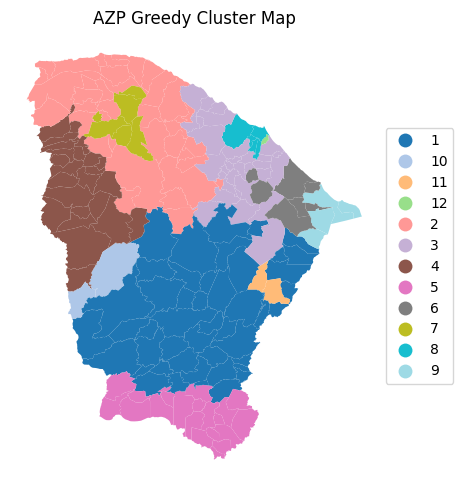

In [9]:
ceara_clusters1 = pygeoda.azp_greedy(n_clusters, queen_w, data_g)
cluster_labels1 = np.array(ceara_clusters1['Clusters'])
print(cluster_stats(cluster_labels1))
fit = cluster_fit(data,cluster_labels1,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels1)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels1, figsize=(5,5), title="AZP Greedy Cluster Map", cmap='tab20')

### AZP-Tabu

The Tabu algorithm for AZP is invoked with `azp_tabu`. In addition to the same arguments as for the basic AZP function, a `tabu_length` is required (the size of the tabu list of observations for which a swap is not possible), as well as the maximum number of non-improving moves, `conv_tabu`. In our illustration, these are set to respectively 50 and 25, as in Chapter 11. We use the same set of functions as before.

    Labels  Cardinality
0        1           50
1        2           41
2        3           26
3        4           25
4        5           14
5        6           10
6        7            5
7        8            4
8        9            4
9       10            2
10      11            2
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.    155.14  119.919  97.683  71.455  78.79   34.08   16.279  53.98
  11.088   2.921  16.99 ]
Total Within-cluster Sum of Squares (WSS): 658.326
Between-cluster Sum of Squares (BSS): 439.674
Ratio of BSS to TSS: 0.4
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.959    0.860    0.803       0.608  0.502   4.575
2           0.968    0.904    0.849       0.693  0.538   4.533
3           0.956    0.780    0.835       0.644  0.542   4.636
4           0.960    0.883    0.852       0.629

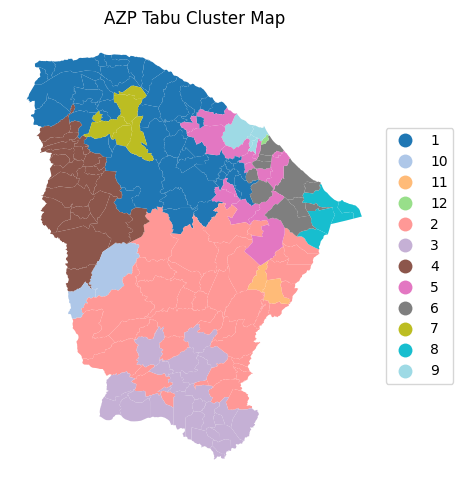

In [10]:
ceara_clusters2 = pygeoda.azp_tabu(n_clusters, queen_w, data_g,
                                   tabu_length = 50, conv_tabu = 25)
cluster_labels2 = np.array(ceara_clusters2['Clusters'])
print(cluster_stats(cluster_labels2))
fit = cluster_fit(data,cluster_labels2,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels2)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels2, figsize=(5,5), title="AZP Tabu Cluster Map", cmap='tab20')

### AZP-Simulated Annealing

The simulated annealing algorithm for AZP is invoked with `azp_sa`. In addition to the same arguments as for the basic AZP function, a `cooling_rate` is required (the rate at which the simulated annealing temperature is allowed to decrease), as well as the maximum number of iterations allowed for each swap, `sa_maxit`. In our illustration, these are set to respectively 0.8 and 5, as in Chapter 11. We use the same set of functions as before.

Note that the results differ slightly from the ones reported in Chapter 11.

    Labels  Cardinality
0        1           71
1        2           33
2        3           28
3        4           19
4        5           12
5        6            5
6        7            5
7        8            4
8        9            2
9       10            2
10      11            2
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.    204.08  101.845 129.825  50.521  41.189   7.637  26.967  53.98
   2.921   1.109  16.99 ]
Total Within-cluster Sum of Squares (WSS): 637.065
Between-cluster Sum of Squares (BSS): 460.935
Ratio of BSS to TSS: 0.42
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.965    0.903    0.847       0.674  0.533   4.621
2           0.958    0.860    0.795       0.586  0.505   4.473
3           0.938    0.816    0.802       0.565  0.453   6.141
4           0.953    0.732    0.834       0.61

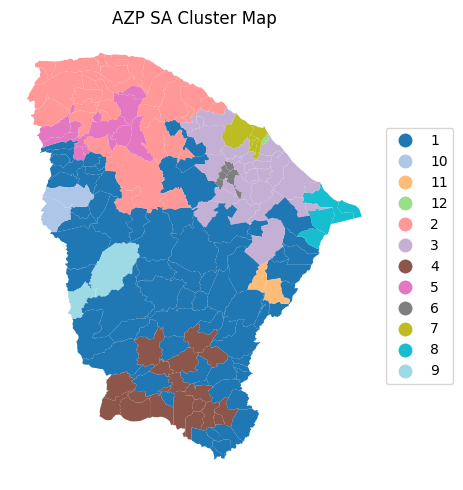

In [11]:
ceara_clusters3 = pygeoda.azp_sa(n_clusters, queen_w, data_g,
                                   cooling_rate=0.8, sa_maxit = 5)
cluster_labels3 = np.array(ceara_clusters3['Clusters'])
print(cluster_stats(cluster_labels3))
fit = cluster_fit(data,cluster_labels3,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels3)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels3, figsize=(5,5), title="AZP SA Cluster Map", cmap='tab20')

### ARiSel

As in K-means, an alternative to a random initial feasible solution is to use a k-means++ like logic. This is implemented in the ARiSel approach, through the additional `inits` argument to any azp function. In the example below, we set `inits=50`. We use `azp_sa` with a `cooling_rate` of 0.8 and `sa_maxit` as 5.

    Labels  Cardinality
0        1           67
1        2           29
2        3           19
3        4           19
4        5           14
5        6           13
6        7            6
7        8            6
8        9            5
9       10            4
10      11            1
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.    224.399  88.688  50.521  51.732  48.429  44.554  39.958   8.893
  16.279  11.088   0.   ]
Total Within-cluster Sum of Squares (WSS): 584.54
Between-cluster Sum of Squares (BSS): 513.46
Ratio of BSS to TSS: 0.468
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.968    0.888    0.844       0.692  0.552   4.663
2           0.954    0.858    0.795       0.586  0.510   4.513
3           0.953    0.732    0.834       0.615  0.545   4.734
4           0.956    0.897    0.855       0.60

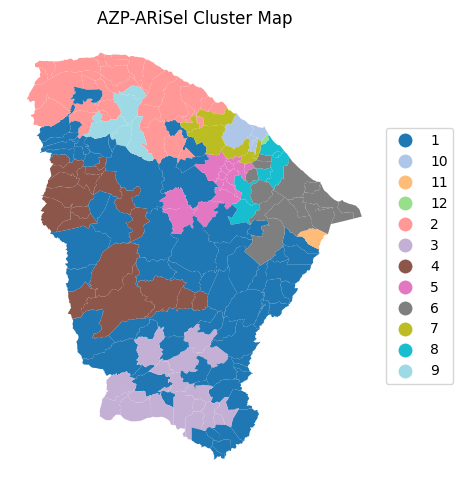

In [12]:
ceara_clusters4 = pygeoda.azp_sa(n_clusters, queen_w, data_g, cooling_rate=0.8, sa_maxit=5, inits=50)
cluster_labels4 = np.array(ceara_clusters4['Clusters'])
print(cluster_stats(cluster_labels4))
fit = cluster_fit(data,cluster_labels4,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels4)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels4, figsize=(5,5), title="AZP-ARiSel Cluster Map", cmap='tab20')

### AZP with initial clustering result

As mentioned in the discussion of hierarchical spatially constrained solutions, one of the drawbacks of these methods is that observations tend to be *trapped* in a branch of the dendrogram or minimum spanning tree. Since AZP implements swapping of observations, we can use the endpoint of one of the hierarchical methods as the feasible initial solution for AZP. In many instances (but not all), this improves on the hierarchical solution and sometimes also obtains better solutions that straight AZP.

In all these illustrations, it is important to keep in mind the sensitivity of the results to the various tuning parameters (which are under the analyst's control) as well as hardware implementations (which are not).

We illustrate this approach by using the end solution of SCHC as the initial solution for AZP, set by means of the `init_regions` argument.

    Labels  Cardinality
0        1           88
1        2           43
2        3           15
3        4           14
4        5            8
5        6            4
6        7            4
7        8            3
8        9            2
9       10            1
10      11            1
11      12            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.    246.863 134.79   30.167  49.716  31.033  14.614  11.088   5.956
  16.99    0.      0.   ]
Total Within-cluster Sum of Squares (WSS): 541.218
Between-cluster Sum of Squares (BSS): 556.782
Ratio of BSS to TSS: 0.507
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.964    0.895    0.847       0.670  0.526   4.600
2           0.950    0.836    0.790       0.578  0.494   4.460
3           0.952    0.719    0.842       0.625  0.575   4.887
4           0.944    0.883    0.837       0.

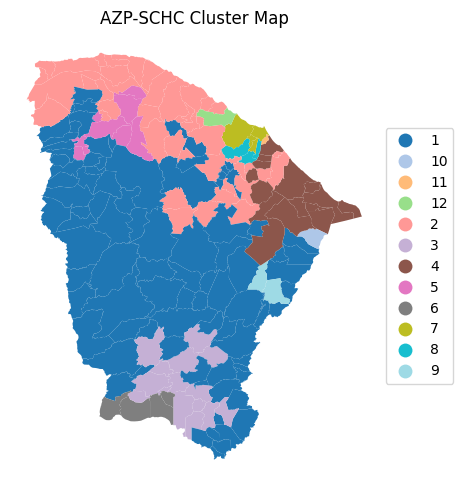

In [13]:
ceara_clusters = pygeoda.schc(n_clusters, queen_w, data_g, "ward")
schc_cluster_labels = ceara_clusters['Clusters']
ceara_clusters5 = pygeoda.azp_sa(n_clusters, queen_w, data_g, cooling_rate=0.8, sa_maxit=5, 
                                init_regions=schc_cluster_labels)
cluster_labels5 = np.array(ceara_clusters5['Clusters'])
print(cluster_stats(cluster_labels5))
fit = cluster_fit(data,cluster_labels5,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels5)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels5, figsize=(5,5), title="AZP-SCHC Cluster Map", cmap='tab20')


### Comparing AZP implementations

To close the discussion of AZP, we provide a brief summary of the spatial layout and measure of fit for the greedy algorithm, the tabu search, and two simulated annealing results, one with 50 initial re-runs and one using SCHC as the starting point. The latter solution clearly achieves the highest BSS/TSS ratio.

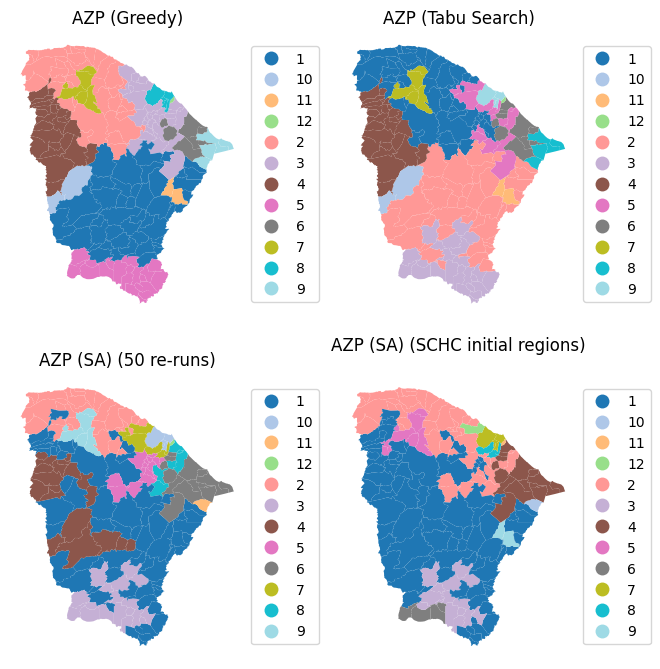

The ratio of between to total sum of squares:
AZP (Greedy) : 0.3723
AZP (Tabu Search) : 0.4004
AZP (SA) (50 re-runs) : 0.4676
AZP (SA) (SCHC initial regions) : 0.5071


In [14]:
# Comparing the results, except the basic AZP (SA) 
titles = ["AZP (Greedy)", "AZP (Tabu Search)",
                   "AZP (SA) (50 re-runs)", "AZP (SA) (SCHC initial regions)"]

cluster_map(dfs, [cluster_labels1, cluster_labels2, cluster_labels4, cluster_labels5], 
            title=titles, cmap='tab20', grid_shape=(2, 2), figsize=(7, 7))

ceara_clusters = [ceara_clusters1, ceara_clusters2, ceara_clusters4, ceara_clusters5]
print("The ratio of between to total sum of squares:")
for i, cluster in enumerate(ceara_clusters):
    print(titles[i],f": {np.round(cluster['The ratio of between to total sum of squares'],4)}")

## Max-p Regions

Up to this point, we had to specify the number of clusters beforehand as the first argument to be passed to the `pygeoda` clustering routines. The max-p approach takes a different perspective as it finds the largest number of clusters possible (the *max p*) within a given constraint on the cluster size. Without such a constraint, the solution would always equal the number of observations.

The minimum cluster size, or `min_bound` is typically a function of the total for a *spatially extensive* variable, like population or total number of housing units. However, it can be set differently as well. Keep in mind that the larger the minimum bound, the smaller the number of clusters that will be found, and the other way around. When the minimum size is not determined by some fixed policy criterion, it may therefore be good to do some experimentation.

The max-p algorithm is essentially AZP applied to an initial feasible solution that follows a heuristic to maximize the number of regions that satisfy the minimum bounds constraint. As before, several random starting points should be explored as the results are quite sensitive to this initial solution.

We illustrate max-p for the Ceara example using simulated annealing with the `min_bound` set to a percentage of the total population. As for AZP, three functions are available, `maxp_greedy`, `maxp_tabu` and `maxp_sa`. The AZP-related arguments are the same as for the core AZP functions. The `n_clusters` argument is (obviously) no longer needed. Instead, the `bound_variable` defines the spatially extensive variable for the minimum constraint, and `min_bound` sets its actual value. Here, we take `'pop'` as the variable (from the geodataframe), and compute the percentage for the bound using `sum()` multiplied by a fraction.

In the first example, we use `maxp_greedy` with a population minimum of 10% of the total, or 845,238. This yields a solution with 6 clusters, achieving a miserable BSS/TSS of 0.26.

   Labels  Cardinality
0       1           64
1       2           45
2       3           35
3       4           30
4       5            8
5       6            2

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.    283.714 150.575 190.247 103.556  69.006  15.465   0.      0.
   0.      0.      0.   ]
Total Within-cluster Sum of Squares (WSS): 812.563
Between-cluster Sum of Squares (BSS): 285.437
Ratio of BSS to TSS: 0.26
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.964    0.847    0.841       0.673  0.545   4.521
2           0.951    0.844    0.792       0.577  0.494   5.009
3           0.951    0.892    0.850       0.644  0.456   6.236
4           0.974    0.878    0.841       0.657  0.554   4.818
5           0.871    0.759    0.777       0.682  0.490  10.228
6           0.891    0.806    0.809       0.680  0.515  21.378
Cluster Me

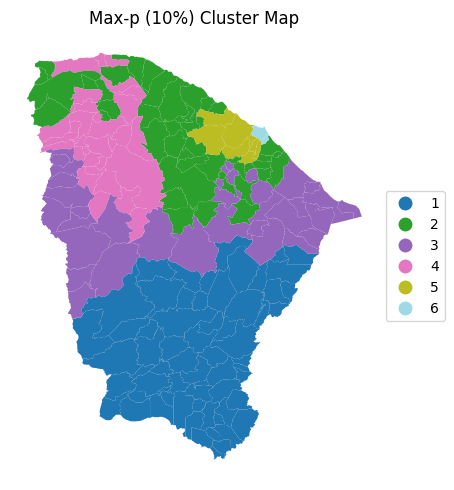

In [15]:
ceara_clusters6 = pygeoda.maxp_greedy(queen_w, data_g, 
                                      bound_variable=dfs['pop'], 
                                      min_bound=dfs['pop'].sum()*0.1)
cluster_labels6 = np.array(ceara_clusters6['Clusters'])
print(cluster_stats(cluster_labels6))
fit = cluster_fit(data,cluster_labels6,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels6)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels6, figsize=(5,5), title="Max-p (10%) Cluster Map", cmap='tab20')

### Sensitivity analysis

The importance of sensitivity analysis for max-p cannot be understated. To illustrate the various outcomes that can be obtained by tuning the various parameters, we give two examples using simulated annealing with a minimum bound of 5% and 3% respectively.

We first consider 5%, i.e., a population minimum of 422,619. We set the number of iterations (`iterations`) to 9999, use a cooling rate of 0.9 and `maxit` of 5. Note that this achieves a p of 13, compared to 12 in Figure 11.28 for `GeoDa`, but the BSS/TSS ratio is 0.347, relative to 0.385 in `GeoDa`.

    Labels  Cardinality
0        1           24
1        2           23
2        3           20
3        4           19
4        5           18
5        6           18
6        7           17
7        8           14
8        9           11
9       10            8
10      11            7
11      12            3
12      13            2

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [  0.     74.807  83.702  32.777  95.473  65.341  69.935  44.14  103.769
  42.53   36.253  68.153]
Total Within-cluster Sum of Squares (WSS): 716.879
Between-cluster Sum of Squares (BSS): 381.121
Ratio of BSS to TSS: 0.347
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.959    0.875    0.845       0.618  0.484   4.593
2           0.963    0.831    0.832       0.614  0.487   4.154
3           0.961    0.907    0.847       0.723  0.548   4.552
4           0.965   

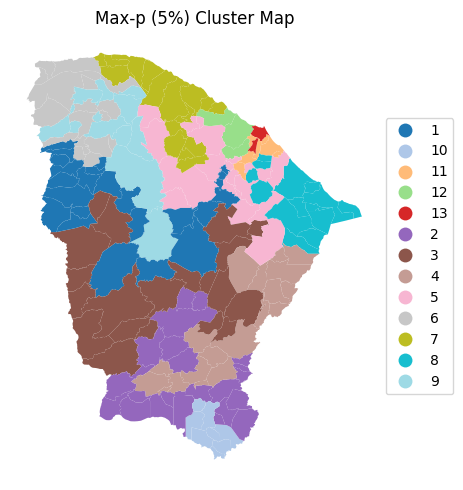

In [16]:
ceara_clusters7 = pygeoda.maxp_sa(queen_w, data_g, 
                                      bound_variable=dfs['pop'], 
                                      min_bound=dfs['pop'].sum()*0.05,
                                      iterations=9999,
                                      cooling_rate=0.9,
                                      sa_maxit=5)
cluster_labels7 = np.array(ceara_clusters7['Clusters'])
print(cluster_stats(cluster_labels7))
fit = cluster_fit(data,cluster_labels7,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels7)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels7, figsize=(5,5), title="Max-p (5%) Cluster Map", cmap='tab20')

In the final example, we set the population minimum to 3%, or 253,571, with the same SA parameters. This yields 19 clusters, with a BSS/TSS ratio of 0.622, considerably better than the solution obtained with `GeoDa`. This again highlights the importance of experimentation with the various parameters.

    Labels  Cardinality
0        1           29
1        2           22
2        3           14
3        4           13
4        5           12
5        6           11
6        7           10
7        8           10
8        9           10
9       10           10
10      11            7
11      12            7
12      13            7
13      14            6
14      15            6
15      16            5
16      17            2
17      18            2
18      19            1

Total Sum of Squares (TSS): 1098.0
Within-cluster Sum of Squares (WSS) for each cluster: [ 0.    93.984 44.641 33.152 36.827 33.059 29.783 23.856 26.853 31.334
 49.377 12.665]
Total Within-cluster Sum of Squares (WSS): 415.532
Between-cluster Sum of Squares (BSS): 682.468
Ratio of BSS to TSS: 0.622
Cluster Means:
          mobility  environ  housing  sanitation  infra  gdpcap
cluster                                                       
1           0.971    0.903    0.840       0.692  0.535   4.248
2           0.

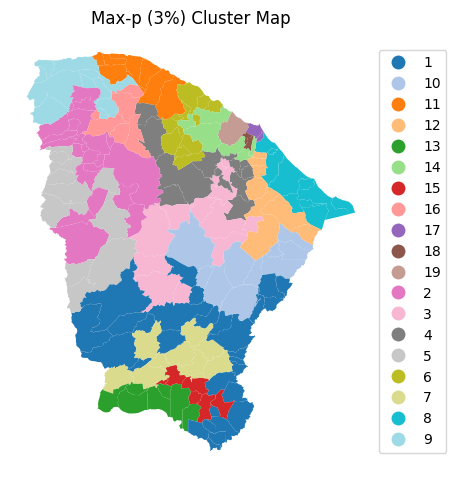

In [17]:
ceara_clusters8 = pygeoda.maxp_sa(queen_w, data_g, 
                                      bound_variable=dfs['pop'], 
                                      min_bound=dfs['pop'].sum()*0.03,
                                      iterations=9999,
                                      cooling_rate=0.9,
                                      sa_maxit=5)
cluster_labels8 = np.array(ceara_clusters8['Clusters'])
print(cluster_stats(cluster_labels8))
fit = cluster_fit(data,cluster_labels8,n_clusters,correct=True,printopt=True)
clust_means,clust_medians = cluster_center(data, cluster_labels8)
print("Cluster Means:\n",np.round(clust_means,3))
print("Cluster Medians:\n",np.round(clust_medians,3))
# Plot the clusters
cluster_map(dfs, cluster_labels8, figsize=(5,5), title="Max-p (3%) Cluster Map", cmap='tab20')